In [ ]:
import os
import pandas as pd
from deepeval.metrics import (
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    ContextualPrecisionMetric,
    ContextualRecallMetric,
    ContextualRelevancyMetric,
)
from tqdm import tqdm
from deepeval.test_case import LLMTestCase
os.environ["OPENAI_API_KEY"] = 'your-api-key'

c:\Users\jakub\OneDrive\Desktop\PW\Natural Language Processing\SciBot\.venv\Lib\site-packages\deepeval\__init__.py:51: UserWarning: You are using deepeval version 2.1.1, however version 2.1.3 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


In [ ]:
answer_relevancy = AnswerRelevancyMetric(model="gpt-4o-mini")
faithfulness = FaithfulnessMetric(model="gpt-4o-mini")
contextual_precision = ContextualPrecisionMetric(model="gpt-4o-mini")
contextual_recall = ContextualRecallMetric(model="gpt-4o-mini")
contextual_relevancy = ContextualRelevancyMetric(model="gpt-4o-mini")
metrics = [answer_relevancy, faithfulness, contextual_precision, contextual_recall, contextual_relevancy]

In [ ]:
df = pd.read_csv("../../data/llm_eval/real_outputs_with_gt.csv")
df.head()

,llm,question,context,answer,ex_time,ground_truth
0,qwen2.5:3b,"What does the term ""learn to optimize"" mean?\n","Document 1: \n NatlSciRev ,2024,Vol.11,nwae132...","The term ""learn to optimize"" (L2O) refers to a...",2.757843,"The term ""learn to optimize"" (L2O) refers to a..."
1,qwen2.5:3b,Please give some examples of metaheuristics.\n,Document 1: \n usually provide only sub-optima...,Metaheuristics are high-level methodologies or...,2.751359,Examples of metaheuristics include Simulated A...
2,qwen2.5:3b,"What is the ""no free lunch"" theorem about?\n",Document 1: \n IEEE TRANSACTIONS ON EVOLUTIONA...,"The ""No Free Lunch"" (NFL) theorem states that ...",2.572277,"The ""no free lunch"" (NFL) theorem for optimiza..."
3,qwen2.5:3b,What is the concept behind Parallel Algorithm ...,Document 1: \n training set as well as for con...,The concept of a Parallel Algorithm Portfolio ...,2.925742,The concept behind a Parallel Algorithm Portfo...
4,qwen2.5:3b,Please provide some approaches to how Parallel...,"Document 1: \n algorithms, and thereby combine...","To construct parallel algorithm portfolios, ef...",3.219646,Several approaches can be used for constructin...


In [ ]:
test_case = LLMTestCase(
    input="What if these shoes don't fit?",
    # Replace this with the actual output of your LLM application
    actual_output="We offer a 30-day full refund at no extra cost.",
    retrieval_context=["All customers are eligible for a 30 day full refund at no extra cost."]
)

answer_relevancy.measure(test_case)

In [ ]:
import re

def clean_math_text(text):
    text = re.sub(r"\\\((.*?)\\\)", r"[\1]", text) 
    text = re.sub(r"\\\[.*?\\\]", "", text)         
    text = re.sub(r"\\begin\{.*?\}.*?\\end\{.*?\}", "", text, flags=re.DOTALL)  

    text = re.sub(r"\\\\", r"\\", text) 
    text = re.sub(r"\\", "", text)   

    text = text.replace("&", "and") 
    text = re.sub(r"\s+", " ", text) 

    return text.strip()

In [11]:
test_cases = [LLMTestCase(
    input=row["question"],
    actual_output=clean_math_text(row['answer']),
    expected_output=clean_math_text(row['ground_truth']),
    retrieval_context=[clean_math_text(row["context"])]
) for _, row in df.iterrows()]

In [14]:
results = []

In [ ]:
for case in tqdm(test_cases):
    results_case = []
    for metric in metrics:
        metric.measure(case)
        results_case.append(metric.score)
        results_case.append(metric.reason)
    results.append(results_case)

In [18]:
results_df = pd.DataFrame(results, columns=[f"{metric.__name__.replace(" ", "_")}_{idx}" for metric in metrics for idx in ["score", "reason"]])

In [19]:
results_df

,Answer_Relevancy_score,Answer_Relevancy_reason,Faithfulness_score,Faithfulness_reason,Contextual_Precision_score,Contextual_Precision_reason,Contextual_Recall_score,Contextual_Recall_reason,Contextual_Relevancy_score,Contextual_Relevancy_reason
0,1.0,The score is 1.00 because the response directl...,1.0,The score is 1.00 because there are no contrad...,1.000000,The score is 1.00 because the relevant node is...,1.0,The score is 1.00 because every aspect of the ...,0.666667,The score is 0.67 because while the retrieval ...
1,1.0,The score is 1.00 because all statements in th...,1.0,The score is 1.00 because there are no contrad...,0.805556,The score is 0.81 because there are relevant n...,1.0,The score is 1.00 because every statement in t...,0.444444,The score is 0.44 because while there are rele...


In [44]:
llms = ["qwen2.5:3b", "qwen2.5:7b", "llama3.1:8b", "llama3.2:3b"]
results_df["model"] = [llms[0]] * 60 + [llms[1]] * 60 + [llms[2]] * 60 + [llms[3]] * 60

In [47]:
results_df

,Answer_Relevancy_score,Answer_Relevancy_reason,Faithfulness_score,Faithfulness_reason,Contextual_Precision_score,Contextual_Precision_reason,Contextual_Recall_score,Contextual_Recall_reason,Contextual_Relevancy_score,Contextual_Relevancy_reason,model
0,1.000000,The score is 1.00 because the answer directly ...,1.000000,The score is 1.00 because there are no contrad...,1.000000,The score is 1.00 because the first node ranks...,0.857143,The score is 0.86 because most of the content ...,0.111111,The score is 0.11 because while the retrieval ...,qwen2.5:3b
1,1.000000,The score is 1.00 because the output directly ...,0.600000,The score is 0.60 because the actual output in...,1.000000,The score is 1.00 because the first node provi...,1.000000,The score is 1.00 because the sentence directl...,0.500000,The score is 0.50 because while some relevant ...,qwen2.5:3b
2,1.000000,The score is 1.00 because the output directly ...,0.750000,The score is 0.75 because the actual output in...,1.000000,The score is 1.00 because the relevant node ra...,1.000000,The score is 1.00 because every aspect of the ...,0.666667,"The score is 0.67 because, while the context i...",qwen2.5:3b
3,0.777778,The score is 0.78 because while the response p...,0.714286,The score is 0.71 because the actual output in...,0.810000,The score is 0.81 because while the first node...,1.000000,The score is 1.00 because every sentence in th...,0.750000,The score is 0.75 because while some relevant ...,qwen2.5:3b
4,1.000000,The score is 1.00 because the output fully add...,0.428571,The score is 0.43 because the actual output in...,1.000000,The score is 1.00 because all the relevant nod...,1.000000,The score is 1.00 because every point in the e...,0.500000,The score is 0.50 because while there are rele...,qwen2.5:3b
...,...,...,...,...,...,...,...,...,...,...,...
235,0.769231,The score is 0.77 because while the response c...,1.000000,The score is 1.00 because there are no contrad...,0.805556,The score is 0.81 because the relevant nodes p...,1.000000,The score is 1.00 because every part of the ex...,0.750000,The score is 0.75 because while the retrieval ...,llama3.2:3b
236,1.000000,The score is 1.00 because there are no irrelev...,0.818182,The score is 0.82 because there are contradict...,0.733333,The score is 0.73 because while there are seve...,1.000000,The score is 1.00 because every aspect of the ...,0.700000,The score is 0.70 because while the retrieval ...,llama3.2:3b
237,1.000000,The score is 1.00 because all statements made ...,0.666667,The score is 0.67 because the actual output cl...,0.666667,The score is 0.67 because while there are rele...,1.000000,The score is 1.00 because every sentence in th...,0.375000,The score is 0.38 because while there are rele...,llama3.2:3b
238,1.000000,The score is 1.00 because the output directly ...,1.000000,The score is 1.00 because there are no contrad...,0.266667,The score is 0.27 because the irrelevant nodes...,1.000000,The score is 1.00 because every aspect of the ...,0.625000,The score is 0.62 because while some statement...,llama3.2:3b


In [20]:
results_df.to_csv("../../data/results/llm_metrics_missing_cases.csv", index=False)

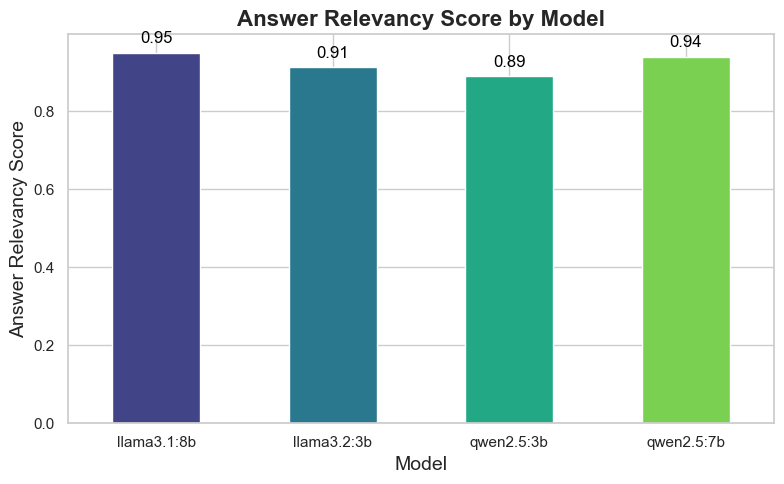

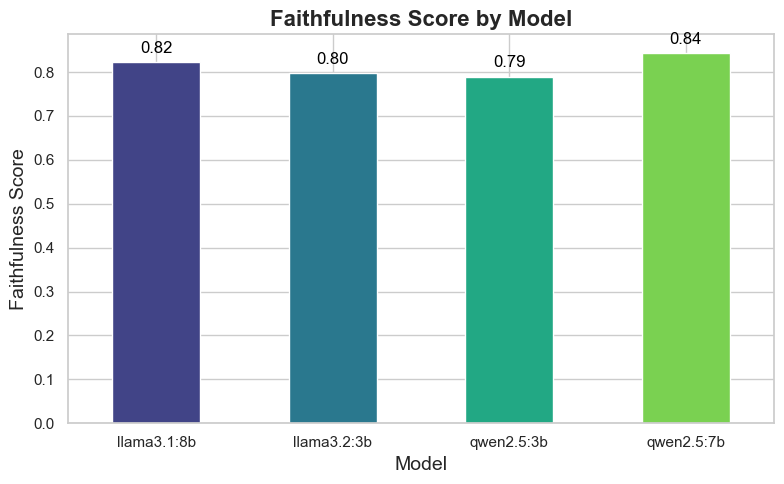

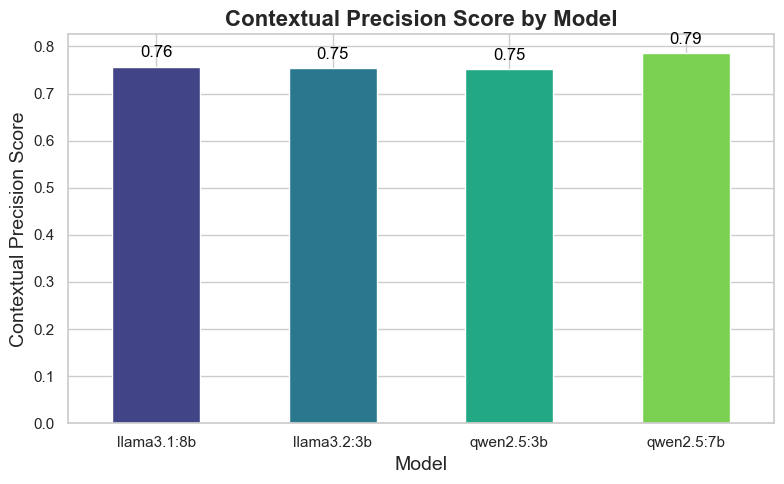

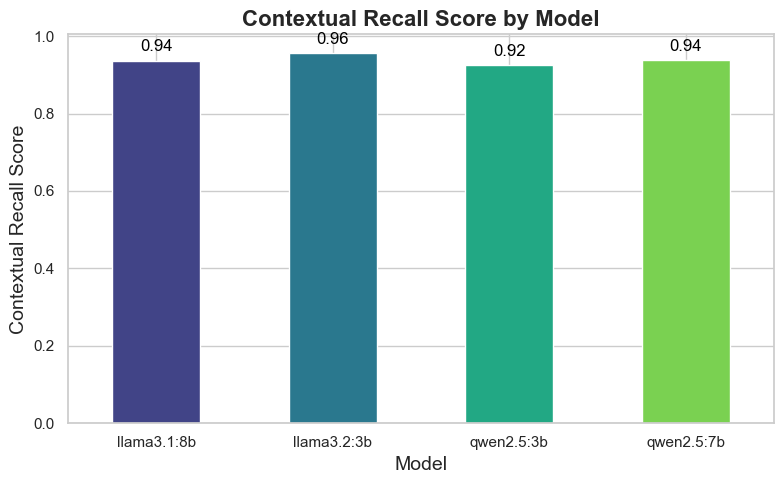

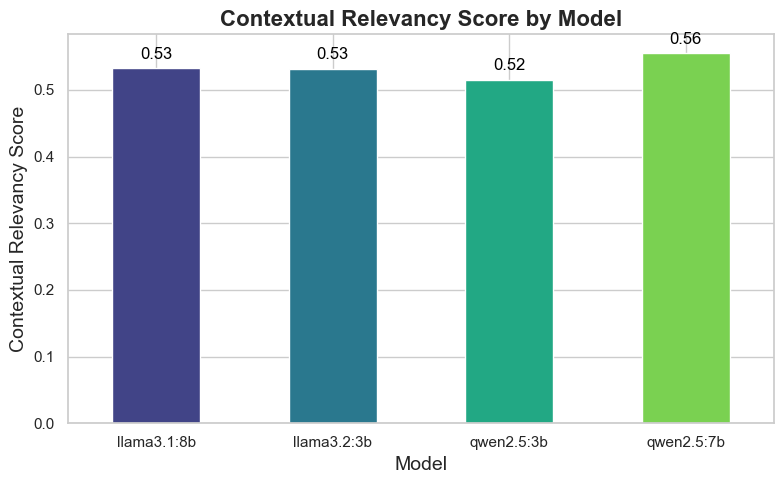

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Loop through each metric and plot with enhanced styles
for metric in metrics:
    # Create a figure with specific dimensions for consistency
    plt.figure(figsize=(8, 5))
    
    # Plot the mean scores for each model, using Seaborn color palette
    ax = results_df.groupby("model")[f"{metric.__name__.replace(' ', '_')}_score"].mean().plot(
        kind="bar", 
        color=sns.color_palette("viridis", len(results_df["model"].unique())),
    )
    
    # Set the title, labels, and rotate x-axis labels for readability
    plt.title(f"{metric.__name__} Score by Model", fontsize=16, weight="bold")
    plt.xlabel("Model", fontsize=14)
    plt.ylabel(f"{metric.__name__} Score", fontsize=14)
    plt.xticks(rotation=0)
    
    # Add the mean score values above each bar for better data insight
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points',
                    fontsize=12,
                    color="black")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

